# Preamble


In [1]:
# reload modules
from importlib import reload

# load pretrained segmentation models (written in pytorch)
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim

# torchvision
from torchviz import make_dot
import torchvision.transforms.v2 as TF

# torchmetrics
from torchmetrics.classification import Dice, BinaryJaccardIndex

# Serialize/Deserialize Json files
import json

# Data Augmentation
import albumentations as A
import albumentations.augmentations.functional as F
from albumentations.pytorch import ToTensorV2

# get data/time with desired format
from datetime import datetime

time_format = "%Y.%m.%d@%H-%M-%S"

# work with images
import cv2
from PIL import Image

# keep numpy use to a min
# as we store our torch.Tensors to GPU Vram but numpy in RAM (it only supports CPU)
import pandas as pd
import numpy as np

# to have a progress bar
from tqdm import tqdm

# To use pretrained segmentation models (implement in PyTorch)

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
# uncomment if wan't to globally aloow sns to handle plot style
# it adds unwanted style (i.e., grid) to .imshow()
# so better to use it a context manager to style only what I want
# >>> with sns.axes_style('darkgrid'):
# >>>     plt.imshow(...)
# sns.set_theme(
#     context="notebook",
#     style="darkgrid",
#     palette="deep",
#     font="sans-serif",
#     font_scale=1,
#     color_codes=True,
#     rc={'axes.grid': False},
# )

# OS/File/Path management
import sys
import os

# load my custom Classes/Functions/etc.
from utils.dataset import SegmentaionDataset
from utils.models.unet import UnetScratch

/home/tekboart/.local/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/tekboart/.local/lib/python3.11/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have 

## Set up GPU use


In [2]:
print("PyTorch ver:", torch.__version__)

# set max_split_size_mb to avoid GPU VRAM (out of MEM error)
# Could use terminal/shell instead:
# for linux: export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'
# for winows: set 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

# force pytorch to use GPU
# use "model.to(device)" later on to force a model use Cuda GPU
print("Can I use GPU?", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device used for calculation (CPU\Cuda):", device)

PyTorch ver: 2.0.1+cu118
Can I use GPU? True
Device used for calculation (CPU\Cuda): cuda:0


## Set Hyperparameters


In [3]:
hyper_params = {
    "lr": 1e-4,
    "batch_size": 8,
    "num_classes": 1,
    "epochs": 10,
    "num_workers": 2,
    "image_height": 384,
    "image_width": 640,
    "num_classes": 1,
    "pin_mem": True,
    "load_model": False,
    "load_model_path": os.path.join("models"),
    "train_img_dir": os.path.join("data", "traincrop", "img"),
    "train_mask_dir": os.path.join("data", "traincrop", "mask"),
    "val_img_dir": os.path.join("data", "valcrop", "img"),
    "val_mask_dir": os.path.join("data", "valcrop", "mask"),
    "test_img_dir": os.path.join("data", "testcrop", "img"),
    "test_mask_dir": os.path.join("data", "testcrop", "mask"),
    "lr_decay_step": 10,
    "lr_decary_factor": 0.5,
}

# device = device
# lr = 1e-4
# # due to limited Mem I values larger than 4 raise GPU MEM Error
# batch_size = 16
# epochs = 10
# num_workers = 2
# # for UNet the H/W must be a factor of 32
# image_height = 384
# image_width = 640
# num_classes = 1
# pin_mem = True
# load_model = False
# load_model_path = os.path.join('models')

# # define path(s)
# train_img_dir = os.path.join("data", "traincrop", "img")
# train_mask_dir = os.path.join("data", "traincrop", "mask")
# val_img_dir = os.path.join("data", "valcrop", "img")
# val_mask_dir = os.path.join("data", "valcrop", "mask")
# test_img_dir = os.path.join("data", "testcrop", "img")
# test_mask_dir = os.path.join("data", "testcrop", "mask")

# Create Dataset


In [4]:
from utils.dataset import get_loaders, SegmentaionDataset
import utils.dataset
reload(utils.dataset)


# Define a set of augmentations (resize, rescale, augmentation, etc.)
train_transform = A.Compose(
    [
        A.Resize(height=hyper_params['image_height'],
                 width=hyper_params['image_width']),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        # A.RandomRotate90(p=1),  # Use only when the img_height==img_width
        # A.Transpose(p=1),  # Use only when the img_height==img_width
        # A.RandomBrightnessContrast(p=0.8),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2,
                      hue=0.2, always_apply=False, p=0.8),
        A.ImageCompression(quality_lower=99, quality_upper=100, p=0.5),
        A.RGBShift(r_shift_limit=10, g_shift_limit=10,
                   b_shift_limit=10, p=0.5),
        # this is for z-scoring
        # TODO: add pretrained model's own preprocess layer
        A.Normalize(mean=[0.0, 0.0, 0, 0], std=[
                    1.0, 1.0, 1.0], max_pixel_value=255.0),
        # ToTensorV2(),
    ],
    # is_check_shapes=False,  # risky
)

# we don't want TTA, just some resize, normalization, etc.
val_transform = A.Compose(
    [
        A.Resize(height=hyper_params['image_height'],
                 width=hyper_params['image_width']),
        # TODO: add pretrained model's own preprocess layer
        A.Normalize(mean=[0.0, 0.0, 0, 0], std=[
                    1.0, 1.0, 1.0], max_pixel_value=255.0),
        # ToTensorV2(),
    ],
    # is_check_shapes=False,  # risky
)

# create our datasets (with our custom Class)
train_ds = SegmentaionDataset(
    image_dir=hyper_params['train_img_dir'],
    mask_dir=hyper_params['train_mask_dir'],
    transform=train_transform,
    mask_suffix="",
    # subset=[0, 10],
)
val_ds = SegmentaionDataset(
    image_dir=hyper_params['val_img_dir'],
    mask_dir=hyper_params['val_mask_dir'],
    transform=val_transform,
    mask_suffix="",
    # subset=[0, 5],
)
test_ds = SegmentaionDataset(
    image_dir=hyper_params['test_img_dir'],
    mask_dir=hyper_params['test_mask_dir'],
    transform=val_transform,
    mask_suffix="",
    subset=[0, 5],
)

# Create Datatset by data loaders
train_loader, val_loader, test_loader = get_loaders(
    train_ds,
    val_ds,
    test_ds,
    hyper_params['batch_size'],
    hyper_params['num_workers'],
    hyper_params['pin_mem'],
)

In [5]:
# (Fast) Using Dataset's __len__ magic method (always work)
print("# train images:", len(train_ds))
print("# val images:", len(val_ds))
print("# test images:", len(test_ds))

# (Slow) Using Data Loader (is a hit or miss)
# print('# train images:', sum(len(batch) for batch in train_loader))
# print('# val images:', sum(len(batch) for batch in val_loader))

# this outputs wrong nume (why??)
# it's not even the #imgs in mini_batch??
# print(len(train_loader))

# train images: 1896
# val images: 348
# test images: 5


## Visualize Dataset(s)


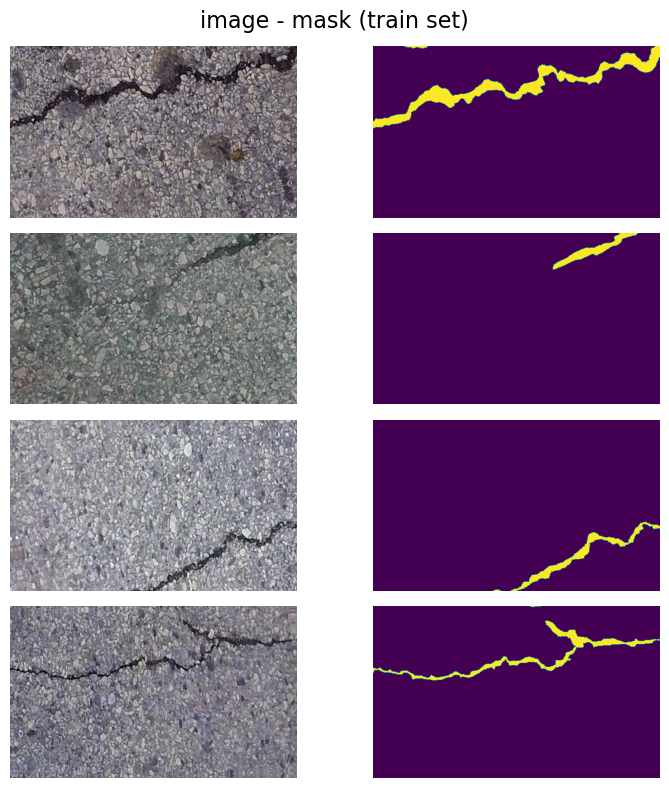

In [6]:
img_mask_iter = ((img, mask) for img, mask in train_ds)

plt.figure(figsize=(8, 8))
for i in range(0, 4 * 2, 2):
    img, mask = next(img_mask_iter)
    plt.subplot(4, 2, i + 1)
    plt.imshow(np.moveaxis(img, 0, -1))
    plt.axis("off")
    plt.subplot(4, 2, i + 2)
    plt.imshow(np.moveaxis(mask, 0, -1))
    plt.axis("off")

plt.suptitle("image - mask (train set)", fontsize=16)
plt.tight_layout()
plt.show()

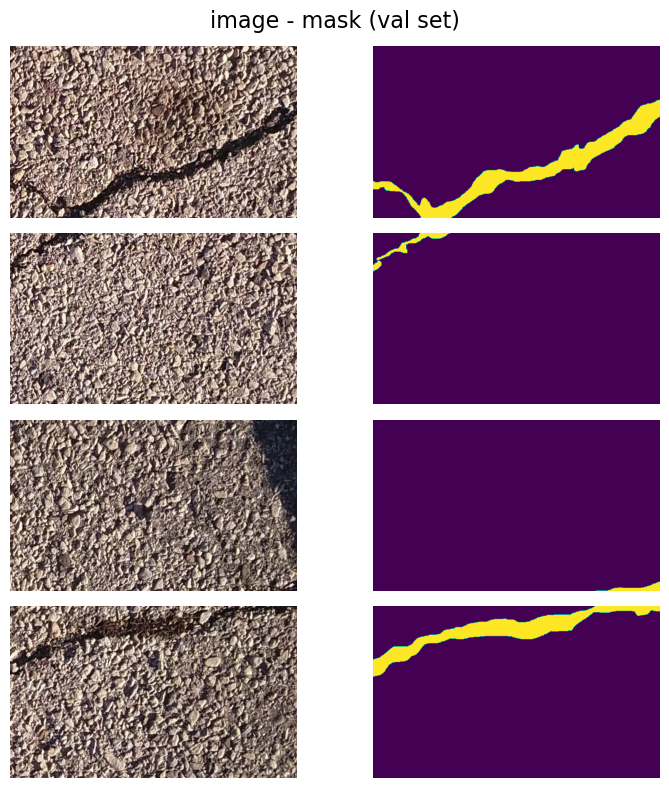

In [7]:
img_mask_iter = ((img, mask) for img, mask in val_ds)

plt.figure(figsize=(8, 8))
for i in range(0, 8, 2):
    img, mask = next(img_mask_iter)
    plt.subplot(4, 2, i + 1)
    plt.imshow(np.moveaxis(img, 0, -1))
    plt.axis("off")
    plt.subplot(4, 2, i + 2)
    plt.imshow(np.moveaxis(mask, 0, -1))
    plt.axis("off")

plt.suptitle("image - mask (val set)", fontsize=16)
plt.tight_layout()
plt.show()

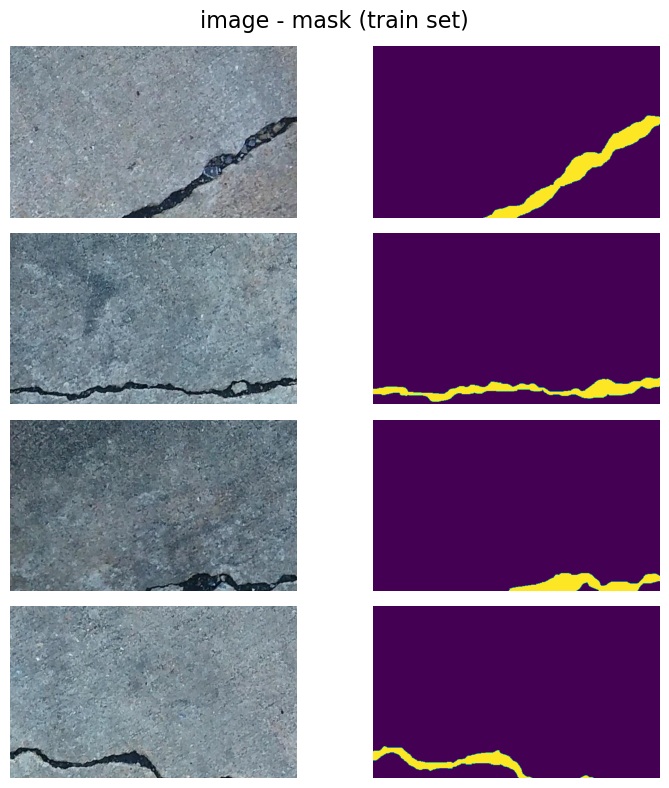

In [8]:
img_mask_iter = ((img, mask) for img, mask in test_ds)

plt.figure(figsize=(8, 8))
for i in range(0, 8, 2):
    img, mask = next(img_mask_iter)
    plt.subplot(4, 2, i + 1)
    plt.imshow(np.moveaxis(img, 0, -1))
    plt.axis("off")
    plt.subplot(4, 2, i + 2)
    plt.imshow(np.moveaxis(mask, 0, -1))
    plt.axis("off")

plt.suptitle("image - mask (train set)", fontsize=16)
plt.tight_layout()
plt.show()

# Define Model(s)


## Import a Pretrained Segmentaion model (e.g., UNET)


In [6]:
# the downloaded model are located in "~/.cache/torch/hub/checkpoints/"
# backbone_model_name = 'resnet152'
backbone_model_name = 'mobilenet_v2'

# Segmentation model is just a PyTorch nn.Module
# model = smp.FPN(
model = smp.Unet(
    # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_name=backbone_model_name,
    # use `imagenet` pre-trained weights for encoder initialization
    encoder_weights="imagenet",
    # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    in_channels=3,
    # model output channels (number of classes in your dataset)
    classes=hyper_params['num_classes'],
)

# load preprocessing func of the loaded model, so our data goes through the same transformation
# hint 1: it needs the input img to be in channels_last format
# hint 2: it outputs the image in channels_last format! (e.g., toch.Size[640, 360, 3])
preprocess_input = get_preprocessing_fn(
    backbone_model_name, pretrained='imagenet')

### Visualize the architecture


In [ ]:
# the attribs of the model
# vars(model)

# plot the model arch
# create a dumy channels_first img (m, C, H, W)
x = torch.zeros(1, 3, 224, 224, dtype=torch.float, requires_grad=False)
# must do a forward pass (to init weights so shapes are set)
yhat = model(x)
print(yhat.shape)

# save the architecture of the model as an image
# make_dot(yhat, params=dict(list(model.named_parameters()))).render("./outputs/model_plot/Unet_pretrained", format="png")

### Test the model with an img


## Load a Segmentation Model (i.e., UNET), written from scratch


In [ ]:
model = UnetScratch(in_channels=3, num_classes=hyper_params["num_classes"])

# Train


In [7]:
from utils.metrics import (
    AccuracyBinarySegment,
    DiceBinarySegment,
    JaccardBinarySegment,
)

from utils.training import train_model
import utils.training
import utils.metrics

reload(utils.training)
reload(utils.metrics)


# a dict to map metrics' name to correspoing fn
metrics_fn = {
    "accuracy": AccuracyBinarySegment(),
    "dice": DiceBinarySegment(),  # my custom dice
    "jaccard": JaccardBinarySegment(),  # my custom jaccard
    # "dice_torch": Dice(average="micro").to(device),
    # "jaccard_torch": BinaryJaccardIndex().to(device),
}

# get the date-time (for filenames)
start_train_time = datetime.today().strftime(time_format)

# save hyperparams as a JSON file
hyper_params_export_name = f"outputs/hyperparams/{start_train_time}@hyperparams.json"
with open(hyper_params_export_name, "w") as f:
    json.dump(hyper_params, f)

# save the hyperparams to a csv file
# df_hyperparam = pd.DataFrame(hyper_params, index=[0]).T
# df_hyperparam.to_csv(f'outputs/hyperparams/{start_train_time}@hyperparams.csv', index=True, header=None)
# print('The HyperParameters'.ljust(79, " "))
# display(df_hyperparam)
# del df_hyperparam

# train the model
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    from_logits=True,
    epochs=hyper_params["epochs"],
    lr=hyper_params["lr"],
    device=device,
    metrics_fn=metrics_fn,
    save_model=True,
    save_model_path="models/",
    save_model_temp=True,
    save_model_temp_path="temp/epoch_best_model_checkpoint/",
)

---------------------------------- epoch 1/10 ---------------------------------


Epoch 1: 100%|██████████| 237/237 [00:20<00:00, 11.71it/s]



loss:                0.371760  
jaccard:             0.42      
dice:                0.57      
accuracy:            0.90      
val_loss:            0.196811  
val_jaccard:         0.54      
val_dice:            0.69      
val_accuracy:        0.97      
---------------------------------- epoch 2/10 ---------------------------------


Epoch 2: 100%|██████████| 237/237 [00:20<00:00, 11.33it/s]



loss:                0.168733  
jaccard:             0.54      
dice:                0.70      
accuracy:            0.96      
val_loss:            0.126103  
val_jaccard:         0.58      
val_dice:            0.72      
val_accuracy:        0.97      
----------------------- Saving Checkpoint (In progress) -----------------------

Checkpoint was saved as: temp/epoch_best_model_checkpoint/temp_model_checkpoint.pth.tar

--------------------------- Saving Checkpoint (Done) --------------------------
---------------------------------- epoch 3/10 ---------------------------------


Epoch 3: 100%|██████████| 237/237 [00:20<00:00, 11.35it/s]



loss:                0.125225  
jaccard:             0.57      
dice:                0.72      
accuracy:            0.97      
val_loss:            0.094465  
val_jaccard:         0.62      
val_dice:            0.75      
val_accuracy:        0.98      
----------------------- Saving Checkpoint (In progress) -----------------------

Checkpoint was saved as: temp/epoch_best_model_checkpoint/temp_model_checkpoint.pth.tar

--------------------------- Saving Checkpoint (Done) --------------------------
---------------------------------- epoch 4/10 ---------------------------------


Epoch 4: 100%|██████████| 237/237 [00:21<00:00, 11.15it/s]



loss:                0.104640  
jaccard:             0.59      
dice:                0.74      
accuracy:            0.97      
val_loss:            0.083415  
val_jaccard:         0.57      
val_dice:            0.71      
val_accuracy:        0.98      
----------------------- Saving Checkpoint (In progress) -----------------------

Checkpoint was saved as: temp/epoch_best_model_checkpoint/temp_model_checkpoint.pth.tar

--------------------------- Saving Checkpoint (Done) --------------------------
---------------------------------- epoch 5/10 ---------------------------------


Epoch 5: 100%|██████████| 237/237 [00:19<00:00, 12.28it/s]



loss:                0.093990  
jaccard:             0.59      
dice:                0.74      
accuracy:            0.97      
val_loss:            0.072908  
val_jaccard:         0.62      
val_dice:            0.75      
val_accuracy:        0.98      
----------------------- Saving Checkpoint (In progress) -----------------------

Checkpoint was saved as: temp/epoch_best_model_checkpoint/temp_model_checkpoint.pth.tar

--------------------------- Saving Checkpoint (Done) --------------------------
---------------------------------- epoch 6/10 ---------------------------------


Epoch 6: 100%|██████████| 237/237 [00:19<00:00, 11.90it/s]



loss:                0.087222  
jaccard:             0.61      
dice:                0.75      
accuracy:            0.97      
val_loss:            0.068339  
val_jaccard:         0.64      
val_dice:            0.77      
val_accuracy:        0.98      
----------------------- Saving Checkpoint (In progress) -----------------------

Checkpoint was saved as: temp/epoch_best_model_checkpoint/temp_model_checkpoint.pth.tar

--------------------------- Saving Checkpoint (Done) --------------------------
---------------------------------- epoch 7/10 ---------------------------------


Epoch 7: 100%|██████████| 237/237 [00:19<00:00, 12.14it/s]



loss:                0.084286  
jaccard:             0.61      
dice:                0.76      
accuracy:            0.97      
val_loss:            0.068053  
val_jaccard:         0.63      
val_dice:            0.76      
val_accuracy:        0.98      
----------------------- Saving Checkpoint (In progress) -----------------------

Checkpoint was saved as: temp/epoch_best_model_checkpoint/temp_model_checkpoint.pth.tar

--------------------------- Saving Checkpoint (Done) --------------------------
---------------------------------- epoch 8/10 ---------------------------------


Epoch 8: 100%|██████████| 237/237 [00:19<00:00, 11.93it/s]



loss:                0.081535  
jaccard:             0.62      
dice:                0.76      
accuracy:            0.97      
val_loss:            0.064484  
val_jaccard:         0.62      
val_dice:            0.75      
val_accuracy:        0.98      
----------------------- Saving Checkpoint (In progress) -----------------------

Checkpoint was saved as: temp/epoch_best_model_checkpoint/temp_model_checkpoint.pth.tar

--------------------------- Saving Checkpoint (Done) --------------------------
---------------------------------- epoch 9/10 ---------------------------------


Epoch 9: 100%|██████████| 237/237 [00:19<00:00, 12.27it/s]



loss:                0.079146  
jaccard:             0.62      
dice:                0.76      
accuracy:            0.97      
val_loss:            0.064302  
val_jaccard:         0.62      
val_dice:            0.75      
val_accuracy:        0.98      
----------------------- Saving Checkpoint (In progress) -----------------------

Checkpoint was saved as: temp/epoch_best_model_checkpoint/temp_model_checkpoint.pth.tar

--------------------------- Saving Checkpoint (Done) --------------------------
--------------------------------- epoch 10/10 ---------------------------------


Epoch 10: 100%|██████████| 237/237 [00:19<00:00, 12.19it/s]



loss:                0.076306  
jaccard:             0.63      
dice:                0.77      
accuracy:            0.97      
val_loss:            0.063183  
val_jaccard:         0.63      
val_dice:            0.76      
val_accuracy:        0.98      
----------------------- Saving Checkpoint (In progress) -----------------------

Checkpoint was saved as: temp/epoch_best_model_checkpoint/temp_model_checkpoint.pth.tar

--------------------------- Saving Checkpoint (Done) --------------------------
----------------------- Saving Checkpoint (In progress) -----------------------

Checkpoint was saved as: models/2023.07.08@09-13-12-model_checkpoint.pth.tar

--------------------------- Saving Checkpoint (Done) --------------------------


In [ ]:
# Check pytorch.cuda GPU VRAM footprint
print(torch.cuda.memory_summary())

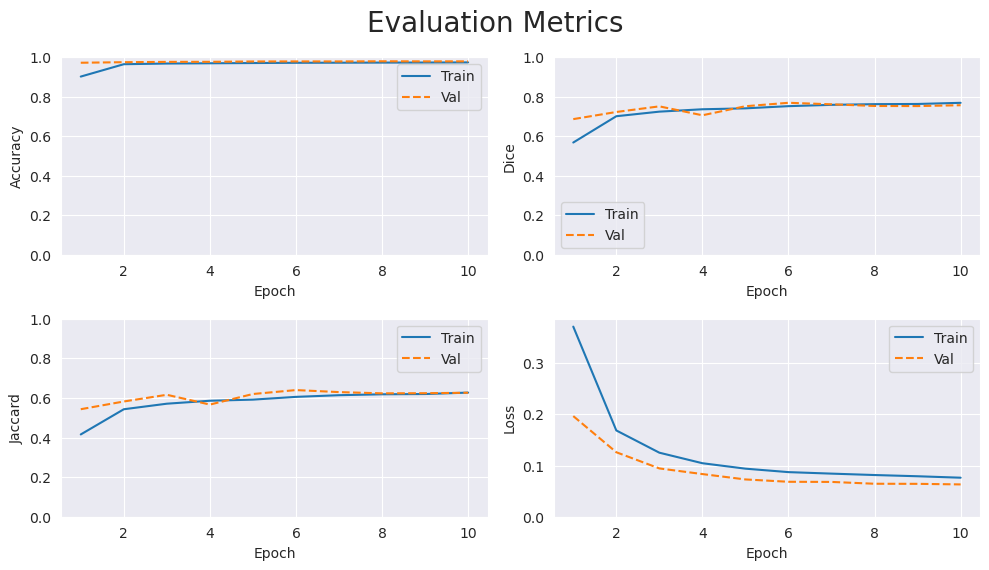

In [13]:
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]


def plot_metrics(
    history: dict, epochs: int, metrics: list = ["loss"], auc_min: float = 0.8
) -> None:
    """
    Plot the metrics (for both the train and val)

    Parameters
    ----------
    history: dict
        the output of model.fit()
    epochs: int
        the #epochs we trained the model
    metrics: list
        a list of metrics to be plotted
    auc_min: 0.8
        as we need to zoom-in more for AUC curve, we use this to limit the range

    returns
    -------
    None
    """
    plt.figure(figsize=(10, 8))
    # take the ceiling of #metrics provided as the #rows
    plot_height = int(len(metrics) / 2) + 1

    for i, metric in enumerate(metrics):
        name = metric.replace("_", " ").title()
        plt.subplot(plot_height, 2, i + 1)
        plt.plot(range(1, epochs + 1),
                 history[metric], color=colors[0], label="Train")
        plt.plot(
            range(1, epochs + 1),
            history["val_" + metric],
            color=colors[1],
            linestyle="--",
            label="Val",
        )
        plt.xlabel("Epoch")
        plt.ylabel(name)
        if metric == "loss":
            plt.ylim([0, plt.ylim()[1]])
        elif metric == "auc":
            plt.ylim([auc_min, 1])
        else:
            plt.ylim([0, 1])

        plt.legend()
        plt.tight_layout()


# allow seaborn to set the style only for this plot
with sns.axes_style("darkgrid", rc={"axes.grid": True}):
    plot_metrics(history, hyper_params["epochs"], list(metrics_fn) + ["loss",])
    plt.suptitle("Evaluation Metrics", fontsize=20)
    plt.tight_layout()
    plt.savefig(
        f"outputs/plots/{start_train_time}@train_val_metric_plot.pdf", bbox_inches="tight")
    plt.show()

In [14]:
df = pd.DataFrame(history)
df.insert(loc=0, column="epoch", value=range(1, len(df.index) + 1))
df.to_csv(f"outputs/history/{start_train_time}@train_plot.csv", index=False)
display(df)
del df

,epoch,loss,accuracy,dice,jaccard,val_loss,val_accuracy,val_dice,val_jaccard
0,1,0.371760,0.901023,0.567932,0.415611,0.196811,0.970890,0.686137,0.543041
1,2,0.168733,0.963478,0.700766,0.542848,0.126103,0.973717,0.722173,0.582052
2,3,0.125225,0.966935,0.723901,0.570887,0.094465,0.975235,0.750618,0.615911
3,4,0.104640,0.968196,0.735896,0.585808,0.083415,0.975549,0.705532,0.566422
4,5,0.093990,0.969384,0.740556,0.591429,0.072908,0.977312,0.751258,0.619856
5,6,0.087222,0.970635,0.751619,0.605388,0.068339,0.977613,0.768640,0.639701
6,7,0.084286,0.971090,0.758220,0.613809,0.068053,0.977462,0.760934,0.629504
7,8,0.081535,0.971640,0.761730,0.618354,0.064484,0.978267,0.752589,0.623230
8,9,0.079146,0.971981,0.762670,0.619751,0.064302,0.977791,0.752013,0.623903
9,10,0.076306,0.972591,0.768431,0.626911,0.063183,0.977938,0.756339,0.626161


# Test (MOVE THIS TO ANOTHER NOTEBOOK AND USE THE SAVED CHECKPOINT MODEL)


In [ ]:
# use the model on test set

In [ ]:
def evaluate_model(model, dataset, metrics) -> dict:
    # calc the yhat
    yhat = train_model(model.cpu(), dataset, from_logits=True)

    # calc metrics
    metrics = 0

    # convert metrics to a dict (e.g., {'accuracy': int, 'dice': int, etc.})

    return metrics


# why evaluate train set?
a = pd.Series(evaluate_model(model, train_loader,
              ['loss',]+list(metrics)), name='Train')
# why evaluate the val set?
b = pd.Series(evaluate_model(model, val_loader, ['loss',]+list(metrics)), name='Val')
c = pd.Series(evaluate_model(model, test_loader,
              ['loss',]+list(metrics)), name='Test')

df = pd.concat([a, b, c], axis=1)
print('Model evaluation on diff sets')
display(df)
del df

# Inference (MOVE THIS TO ANOTHER NOTEBOOK AND USE THE SAVED CHECKPOINT MODEL)

> for single images


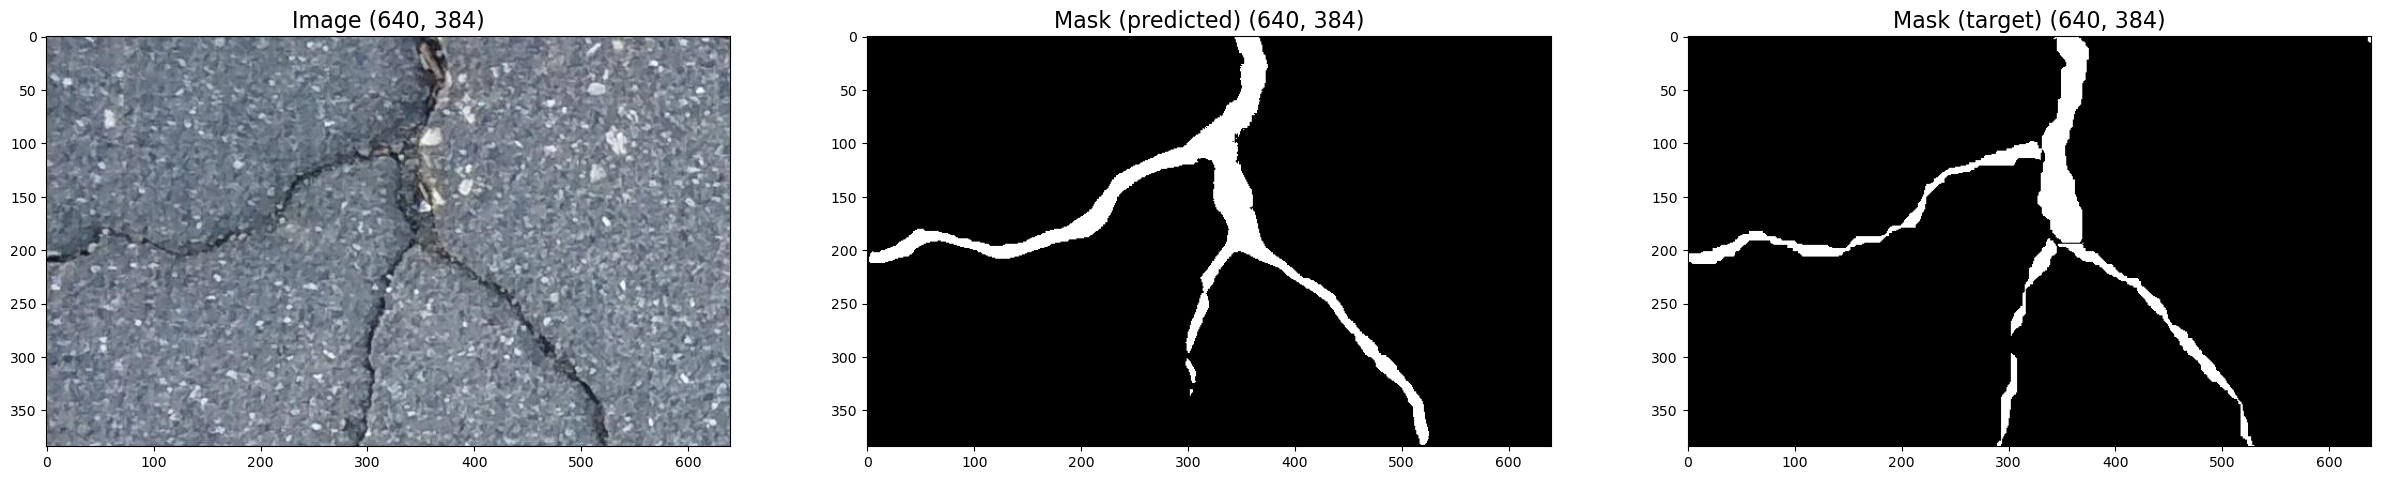

In [16]:
# Lowres images
# img 1 (from traincrop)
# img_filename =  '20160222_081011_1_721.jpg'
# mask_filename = '20160222_081011_1_721_mask.png'
# img 2 (from testcrop)
img_filename = '20160307_164226_1_1.jpg'
mask_filename = '20160307_164226_1_1_mask.png'
# Highres images (from train)
# img_filename =  '20160222_081102.jpg'
# mask_filename = '20160222_081102_mask.png'
img_addr = os.path.join('images', img_filename)
mask_addr = os.path.join('images', mask_filename)

img = Image.open(img_addr).resize((hyper_params['image_width'], hyper_params['image_height']))
mask = Image.open(mask_addr).resize((hyper_params['image_width'], hyper_params['image_height']))

# normalize [-1, 1] the PIL image as a torch.Tensor
img_tensor = (TF.functional.pil_to_tensor(img) / 127.5 - 1).to(device)

yhat = model(img_tensor.unsqueeze(dim=0))
yhat_c_last = yhat[0].moveaxis(0, -1).detach().cpu().numpy()
thresh = 0.5
mask_batch = np.where(yhat_c_last >= thresh, 255, 0)

fig, axes = plt.subplots(1, 3, figsize=(30, 10))
axes[0].imshow(img)
axes[0].set_title(f'Image {img.size}', fontsize=16)
axes[1].imshow(mask_batch, cmap='gray')
axes[1].set_title(
    f'Mask (predicted) {mask_batch.shape[:2][::-1]}', fontsize=16)
axes[2].imshow(mask, cmap='gray')
axes[2].set_title(f'Mask (target) {mask.size}', fontsize=16)
plt.savefig(f'outputs/Inferences/{start_train_time}@{img_filename}.png', bbox_inches='tight')
plt.show()

In [ ]:
from utils.visualization import torch_tensor_for_plt, plot_segmentation_inference
from utils.inferencing import inference_segmentation, img_to_inference_tensor
import utils.inferencing
import utils.visualization
reload(utils.inferencing)
reload(utils.visualization)


img_filename = '20160222_081011_1_721.jpg'
mask_filename = '20160222_081011_1_721_mask.jpg'
img_addr = os.path.join('images', img_filename)
mask_addr = os.path.join('images', mask_filename)

# only for one image, if multiple use utils.dataset
test_img_batch = img_to_inference_tensor(
    img_addr, size=(hyper_params['image_height'], hyper_params['image_width']))
test_mask_batch = img_to_inference_tensor(
    mask_addr, size=(hyper_params['image_height'], hyper_params['image_width']))

# make an inference
yhat_mask = inference_segmentation(
    test_img_batch, model=model, normalize=True, device=device)

# make torch.Tensors ready for pyplot
test_img_batch = torch_tensor_for_plt(test_img_batch)
test_mask_batch = torch_tensor_for_plt(test_mask_batch)
yhat_mask = torch_tensor_for_plt(yhat_mask)

# plot the inference
plot_segmentation_inference(test_img_batch, test_mask_batch, yhat_mask)

#
